In [37]:
using LinearAlgebra
using SparseArrays

using Plots
using LaTeXStrings

using gmsh

# Define Geometry

In [38]:
gmsh.finalize();
gmsh.initialize();

In [39]:
gmsh.open("geo/coil_geo.msh")

# Retrieve nodes from gmsh and sort in order of x-coords
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

Info    : Reading 'geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading 'geo/coil_geo.msh'


In [40]:
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(1)
nelements = length(element_ids[1])

ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 4)
e_group = zeros(1,nelements)

for element_id in 1:nelements
    node1_id = element_connectivity[1][2*(element_id-1)+1]
    node2_id = element_connectivity[1][2*(element_id-1)+2]

    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1]) # Air
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1]) # Core
    G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1]) # Coil left
    G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1]) # Coil right
    
    if G1 == 2
        e_group[element_id] = 1;
    elseif G2 == 2
        e_group[element_id] = 2;
    elseif G3 == 2
        e_group[element_id] = 3;
    elseif G4 == 2
        e_group[element_id] = 4;
    end
end

# Auxiliary functions

In [41]:
function get_idx(node_id, nids)
    return findall(x -> x == node_id, nids)[1];
end

function bnd_dirichlet(idx, a, A, f)
    A[idx,:]   = zeros(length(f));
    A[idx,idx] = 1;
    f[idx] = a;
    
    return A, f;
end

bnd_dirichlet (generic function with 1 method)

# Linear Elements

In [101]:
#..Set the source function 
J = 2.15e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

mu0 = 4e-7 * pi;
mu_r = 1500;
fmu(group_id) = mu0 + (mu_r - 1) * mu0 * (group_id == 2);
fnu(group_id) = 1 / fmu(group_id);
fnu_elem = map(fnu, e_group);

sigma_core = 1e2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 0.2e6;
omega = 2*pi*f;

In [102]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1] for i in 1:length(x)-1); 

#..Initialize global matrix and right-hand side value 
A = zeros(Complex{Float64}, length(x), length(x)); 
f = zeros(Complex{Float64}, length(x)); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xr = points[i,:][1]
    h = xr - xl;
    
    floc = h/2 * [1; 1] * fsource_elem[i];
    Aloc = fnu_elem[i] / h * [1 -1; -1 1] + 1im * omega * fsigma_elem[i] * [1/3 1/6; 1/6 1/3] * h; 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A, f = bnd_dirichlet(get_idx(1, nids), 0, A, f);    # Boundary at x = 0
A, f = bnd_dirichlet(get_idx(8, nids), 0, A, f);    # Boundary at x = 1

#..solve the linear system
u  = A \ f;

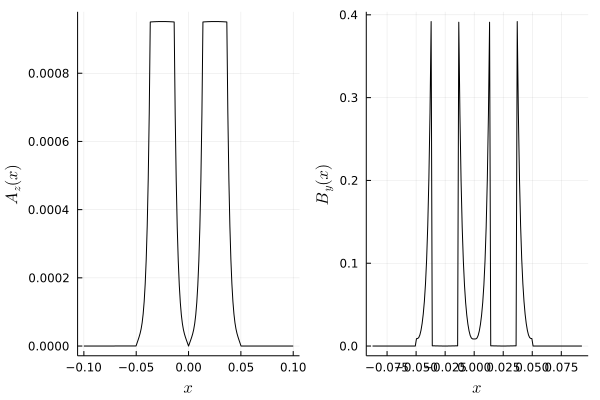

In [103]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x, norm.(u), xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(xmid, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)

# Quadratic Elements

In [104]:
Na = 2 * length(x) - 1;
points = collect( [x[i], 0.5*(x[i] + x[i+1]), x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1, i+2] for i in 1:2:Na-1); 

X = collect([points[i][1], points[i][2]] for i in 1:length(points))
X = reduce(vcat, X);
X = vcat(X, x[end]);

In [105]:
#..Initialize global matrix and right-hand side value 
A = zeros(Complex{Float64}, Na, Na); 
f = zeros(Complex{Float64}, Na); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    h = xr - xl;
    
    floc = h/6 * [1; 4; 1] * fsource_elem[i];
    Aloc = fnu_elem[i] * [7 -8 1; -8 16 -8; 1 -8 7] / (3 * h) + 1im * omega * fsigma_elem[i] * [2/15 1/15 1/30; 1/15 8/15 -1/15; 1/30 -1/15 2/15] * h; 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,:]   = zeros(Na);  A[1,1]     = 1;      f[1]   = 0;
A[end,:] = zeros(Na);  A[end,end] = 1;      f[end]   = 0;

#..solve the linear system
u  = A \ f;

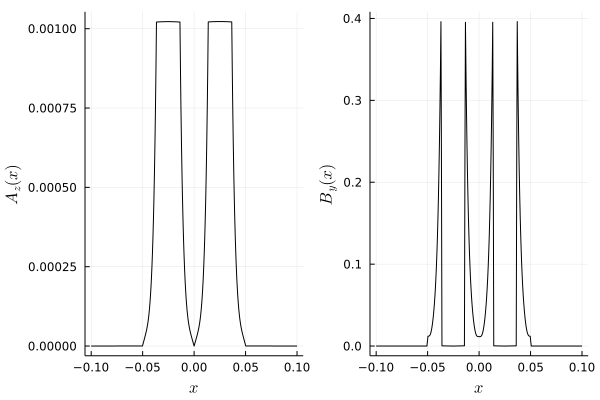

In [106]:
# Post-processing
ux    = zeros(Complex{Float64}, Na);
Jeddy = zeros(Complex{Float64}, Na);

Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    ul, um, ur = u[edges[i]];
    
    dux = [ul um ur] * Emat / (xr - xl);
    
    ux[edges[i]] += [dux[1]/2; dux[2]; dux[3]/2];
    
    Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul/2 um ur/2]';
end

# Plot
p1 = plot(X, norm.(u), xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(X, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)

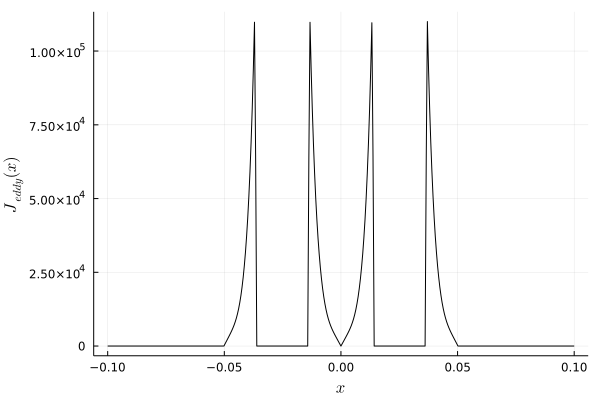

In [107]:
plot(X, norm.(Jeddy), xlabel = L"x", ylabel = L"J_{eddy}(x)", color = :black, lw = 1, legend = false)